# <center> EDA-4-10. Практика. Статистические тесты в контексте EDA.

## <center> Исследование данных HR-агенства.

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы. Нам дали некоторые данные, которые и необходимо проанализировать для получение ответов на некоторые вопросы. Немного подробнее о данных:

|*Название столбца*|*Описание*                                                                                                                                                                    |
|:----------------:|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|work_year         |Год, котором была выплачена зарплата.                                            |
|experience_level  |Опыт работы на этой должности в течение года со следующими возможными значениями: <br>  - EN — Entry-level/Junior; <br>  - MI — Mid-level/Intermediate; <br>  - SE — Senior-level/Expert; <br>  - EX — Executive-level/Director.|
|employment_type   |Тип трудоустройства для этой роли: <br> - PT — неполный рабочий день; <br> - FT — полный рабочий день; <br> - CT — контракт; <br> - FL — фриланс.|
|job_title         |Роль, в которой соискатель работал в течение года.|
|salary            |Общая выплаченная валовая сумма заработной платы.|
|salary_currency   |Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.|
|salary_in_usd     |Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).|
|employee_residence|Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.|
|remote_ratio|Общий объём работы, выполняемой удалённо. Возможные значения: <br> - 0 — удалённой работы нет (менее 20 %); <br> - 50 — частично удалённая работа; <br> - 100 — полностью удалённая работа (более 80 %).|
|company_location|Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.|
|company_size|Среднее количество людей, работавших в компании в течение года: <br> - S — менее 50 сотрудников (небольшая компания); - M — от 50 до 250 сотрудников (средняя компания); <br> - L — более 250 сотрудников (крупная компания).|

### Цели и задачи работы:

Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстривать использование разных тестов для проверки статистической значимости сделанных выводов:

1. тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок;
2. тест для категориальных признаков.

In [104]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные были скопированы из урока, но я продублировал их на [Google Drive](https://drive.google.com/file/d/1-Jmg4_s6DIm0MQP13Q6jRhDd8euweRgd/view?usp=drive_link), для удобства.

Для прямого скачивания воспользуйстесь блоком ниже (предварительно убрав '#'; данные появятся в локальной директории):

In [105]:
# !wget "https://drive.google.com/uc?export=download&id=1-Jmg4_s6DIm0MQP13Q6jRhDd8euweRgd" -O salaries_data.csv

In [106]:
# Загружаем данные

salaries_data = pd.read_csv('data/ds_salaries.csv', index_col=0)
display(salaries_data)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [107]:
# Задаём уровень значимости
alpha = 0.05
print(f'Уровень значимости alpha = {alpha}.')

Уровень значимости alpha = 0.05.


## <center> Очистка данных

In [108]:
#Выведем основную информацию о датасете
display(salaries_data.info())


#Проверка данных на наличие дубликатов
print('Количество дубликатов:', 
salaries_data[salaries_data.duplicated()].shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


None

Количество дубликатов: 42


Размерность датасета 607х11. Пропущеных значений и дубликатов нет.

Сами данные и их типы подозрений также не вызывают, кроме столбца remote_ratio, которые хоть и является категориальным, но представлен в числовом формате, несмотря на то, что он может иметь всего 3 значения.

У нас имеюются колонки, связанные с заработными платами, аж 3 штуки. Думаю, целесообразно будет убрать колонки "salary" и "salary_currency", так как из них выведен более универсальный признак, трансформирующий заработную плату в доллары.

Также в процессе работы не нашел применение признаку 'employee_residence', по сему его тоже удаляю, ведь есть более информативный в сфере исследования - вышеупомянутый remote_ratio.

In [109]:
salaries_data = salaries_data.drop(columns=['salary', 'salary_currency', 'employee_residence'])
salaries_data

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,50,US,L
...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,100,US,M
603,2022,SE,FT,Data Engineer,126000,100,US,M
604,2022,SE,FT,Data Analyst,129000,0,US,M
605,2022,SE,FT,Data Analyst,150000,100,US,M


Теперь для удобства перекодирую признак remote_ratio. Так как в задаче нет ни слова о том, что данные будут использоваться для машинного обучения, закодирую в читабельном для человека варианте.

In [110]:
salaries_data['remote_ratio'] = salaries_data['remote_ratio'].replace(
    {0:'around_zero', 50:'half-time', 100:'full-time'})

salaries_data

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,around_zero,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,around_zero,JP,S
2,2020,SE,FT,Big Data Engineer,109024,half-time,GB,M
3,2020,MI,FT,Product Data Analyst,20000,around_zero,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,half-time,US,L
...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,full-time,US,M
603,2022,SE,FT,Data Engineer,126000,full-time,US,M
604,2022,SE,FT,Data Analyst,129000,around_zero,US,M
605,2022,SE,FT,Data Analyst,150000,full-time,US,M


Проведём корреляционный анализ признаков с помощью тепловой карты.

<Axes: >

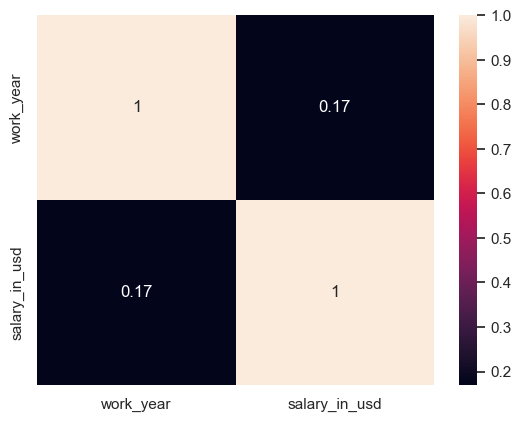

In [111]:
sns.heatmap(salaries_data.corr(numeric_only=True), annot=True)

Ничего подозрительного, числовые признаки логически зависимы, что довольно очевидно; но очень слабо.

На самом деле, признак года едва ли можно назвать числовым. Его следовалы бы закодировать, но делать этого не буду, опять же, для лучшей читаемости. Но изменю тип данных признаков.

In [112]:
coll_list = ['work_year', 'experience_level', 'employment_type', 'job_title', 'remote_ratio', 'company_location', 'company_size']
salaries_data[coll_list] = salaries_data[coll_list].astype('category')

salaries_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   work_year         607 non-null    category
 1   experience_level  607 non-null    category
 2   employment_type   607 non-null    category
 3   job_title         607 non-null    category
 4   salary_in_usd     607 non-null    int64   
 5   remote_ratio      607 non-null    category
 6   company_location  607 non-null    category
 7   company_size      607 non-null    category
dtypes: category(7), int64(1)
memory usage: 19.3 KB


Рассмотрим признак Job_title. У нас в задании есть информация о необходимости рассмотрения только вакансий специалистов data scientist и data engineer. Остальных отметаем. На всякий случай здесь сделаю копию датасета, она может пригодиться далее.

Text(0.5, 1.0, 'Отношение нужных профессий для исследования ко всем остальным')

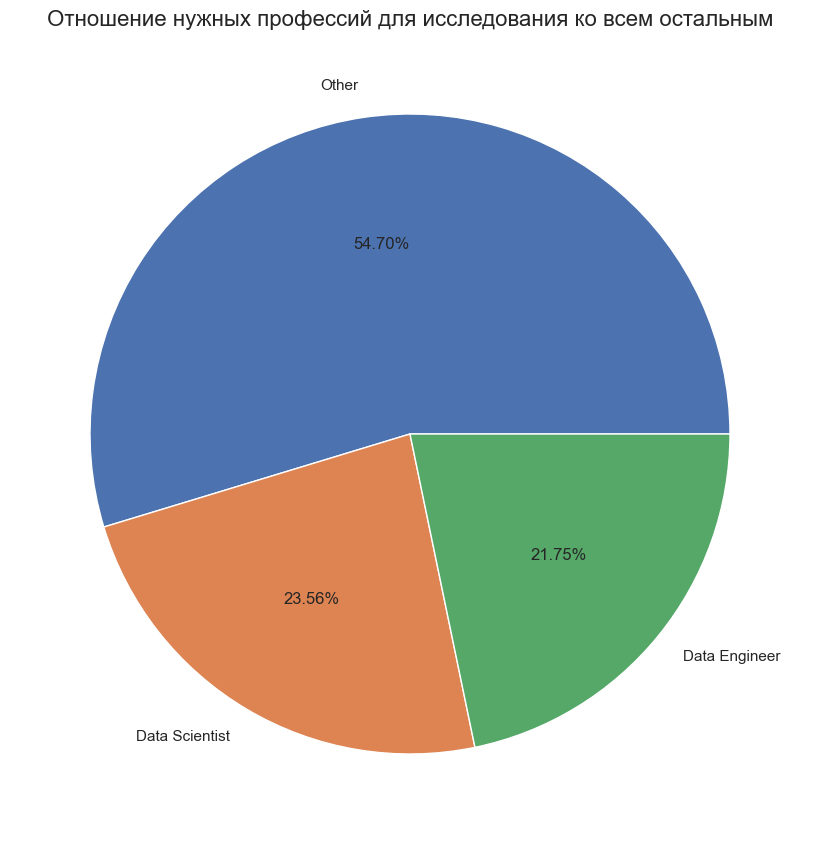

In [113]:
#Список нужных нам профессий
jobs_in_research = ['Data Scientist', 'Data Engineer']

#Копия данных со всеми профессиями на будущее
salaries_data_copy = salaries_data.copy()


salaries_data['job_title'] = salaries_data['job_title'].apply(lambda x: x if x in jobs_in_research else 'Other')

job_mask = salaries_data['job_title'].value_counts()
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    job_mask,
    labels=job_mask.index,
    colors=sns.color_palette('deep')[0:3],
    autopct='%.2f%%'
)
axes.set_title('Отношение нужных профессий для исследования ко всем остальным', fontsize=16)

## <center> Описательный анализ данных

Посмотрим на признаки более внимательно, а также визуализирем их и попробуем найти зависимости и интересные моменты.

Для начала рассмотрим зависимость заработной платы от года.

In [114]:
# Весь рынок исходя из предоставленных данных
fig1 = px.box(
    data_frame=salaries_data,
    x = 'salary_in_usd',
    y = 'work_year',
    title='Коробчатая диаграмма зависимости ЗП от рабочего года',
    labels={'work_year':'Год наблюдения',
            'salary_in_usd':'Заработная плата в USD'}
)

fig1

А теперь посмотрим на распределение заработных плат дата-инженеров и дата-саентистов отдельно:

In [115]:
# ЗП дата-инженеров
data_engineer_mask = salaries_data[salaries_data['job_title'] == 'Data Engineer']

fig2 = px.box(
    data_frame=data_engineer_mask,
    x = 'salary_in_usd',
    y = 'work_year',
    title='Коробчатая диаграмма зависимости ЗП дата-инженеров от рабочего года',
    labels={'work_year':'Год наблюдения',
            'salary_in_usd':'Заработная плата в USD'}
)

fig2

In [116]:
# ЗП дата-саентистов
data_scientist_mask = salaries_data[salaries_data['job_title'] == 'Data Scientist']

fig3 = px.box(
    data_frame=data_scientist_mask,
    x = 'salary_in_usd',
    y = 'work_year',
    title='Коробчатая диаграмма зависимости ЗП дата-саентистов от рабочего года',
    labels={'work_year':'Год наблюдения',
            'salary_in_usd':'Заработная плата в USD'}
)

fig3

In [117]:
# Дополнительно изучим потенциальные выбросы
display(salaries_data_copy[(salaries_data_copy['job_title'] == 'Data Engineer') & (salaries_data_copy['salary_in_usd'] > 300000)])
display(salaries_data_copy[(salaries_data_copy['job_title'] == 'Data Scientist') & (salaries_data_copy['salary_in_usd'] > 300000)])

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
482,2022,EX,FT,Data Engineer,324000,full-time,US,M


,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
63,2020,SE,FT,Data Scientist,412000,full-time,US,L


#### Из этих графиков можно сделать следующие выводы:

1) В целом зарплата обеих должностей увеличивалась из года в год. В 2020, скорее всего из-за Covid-19, минимальная планка ЗП была чуть выше обычной. Но для для полноты утверждения нужны данные за более далёкие годы. Медианные же значения увеличивались из года в год.

По сравнению с остальным рынком, зарплаты обеих исследуемых профессий в 2020 и 2021 были в среднем чуть ниже рынка, но в 2022 они сильно выросли, догнали и даже чуть перегнали остальной рынок. Полагаю, это связано с всеобщей популярностью нейросетей, которая особенно начала прослеживаться как раз с 2022.

2) Максимальные вилки и медианные ЗП обеих должностей увеличивались из года в год. Даже с учётом прошлого утверждения.

3) На графиках обеих профессий имеется по одному потенциальному выбросу. Сказать, что это точно выбросы, нельзя, так как при их более подробном исследовании выясняется, что один из них директор компании из не самой скромной и маленькой компании США (размер компании средний), а это случай особый, и зарплата тут может быть самая разная. Второй выброс - сеньёр Дата-саентист из большой компании США. Возможно, этот кадр стоил своей ЗП. 

В обоих случаях пока не вижу смысла списывать их из исследований.

Посмотрим на градацию заработной платы в зависимости от уровня навыков работника (Среди дата-инженеров и дата-саентистов)

In [118]:
# ЗП дата-инженеров

fig4 = px.box(
    data_frame=data_engineer_mask,
    x = 'salary_in_usd',
    y = 'experience_level',
    title='Коробчатая диаграмма зависимости ЗП дата-инженеров от уровня навыков',
    labels={'experience_level':'Уровень навыков',
            'salary_in_usd':'Заработная плата в USD'}
)

fig4

In [119]:
# ЗП дата-саентистов

fig5 = px.box(
    data_frame=data_scientist_mask,
    x = 'salary_in_usd',
    y = 'experience_level',
    title='Коробчатая диаграмма зависимости ЗП дата-саентистов от уровня навыков',
    labels={'experience_level':'Уровень навыков',
            'salary_in_usd':'Заработная плата в USD'}
)

fig5

In [120]:
# Количество людей с должностью директора
display(salaries_data[(salaries_data['experience_level'] == 'EX') &
                      ((salaries_data['job_title'] == 'Data Engineer') | 
                       (salaries_data['job_title'] == 'Data Scientist'))])


,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
309,2022,EX,FT,Data Engineer,242000,full-time,US,M
310,2022,EX,FT,Data Engineer,200000,full-time,US,M
482,2022,EX,FT,Data Engineer,324000,full-time,US,M
483,2022,EX,FT,Data Engineer,216000,full-time,US,M


Итого у нас имеется довольно стандартное распределение заработных плат в зависимости от предполагаемого уровня умений, где в порядке возрастания идут: Junior --> Middle --> Senior --> Team Lead или директор.

Всего у нас в таблице 4 лида или директора, все из США с внушительными заработными платами. Интересно, что у нас есть данные о них только за 2022 год.

Посмотрим, есть ли различие зарплат дата-инженеров и дата-саентистов в зависимости от размера компании.

In [121]:
# ЗП дата-саентистов

fig6 = px.box(
    data_frame=data_scientist_mask,
    x = 'salary_in_usd',
    y = 'company_size',
    title='Коробчатая диаграмма зависимости ЗП дата-саентистов от размера компании',
    labels={'company_size':'Размер компании',
            'salary_in_usd':'Заработная плата в USD'}
)

fig6

In [122]:
# ЗП дата-инженеров

fig7 = px.box(
    data_frame=data_engineer_mask,
    x = 'salary_in_usd',
    y = 'company_size',
    title='Коробчатая диаграмма зависимости ЗП дата-инженеров от размера компании',
    labels={'company_size':'Размер компании',
            'salary_in_usd':'Заработная плата в USD'}
)

fig7

Судя по графикам, можно сказать, что платят лучше всего обоим специальностям в компаниях средних размеров. Видимо, у маленьких денег не так много, а большие предпочитают больше вкладывать в расширение компании, её компетенций и влияния.

Посмотрим, есть ли взаимосвязь между размерами компании и наличием долностей Data Scientist и Data Engineer.

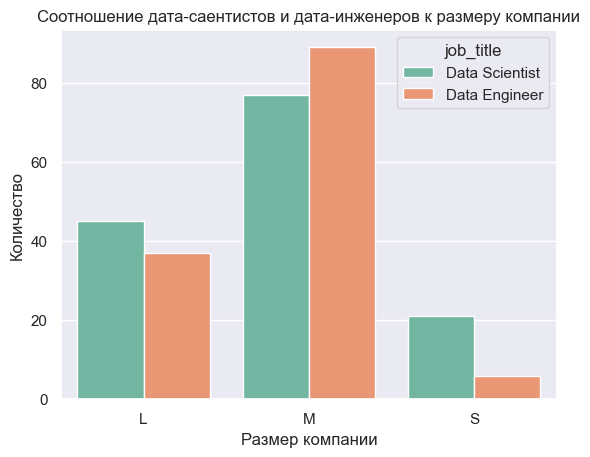

Text(0.5, 1.0, 'Отношение вакансий')

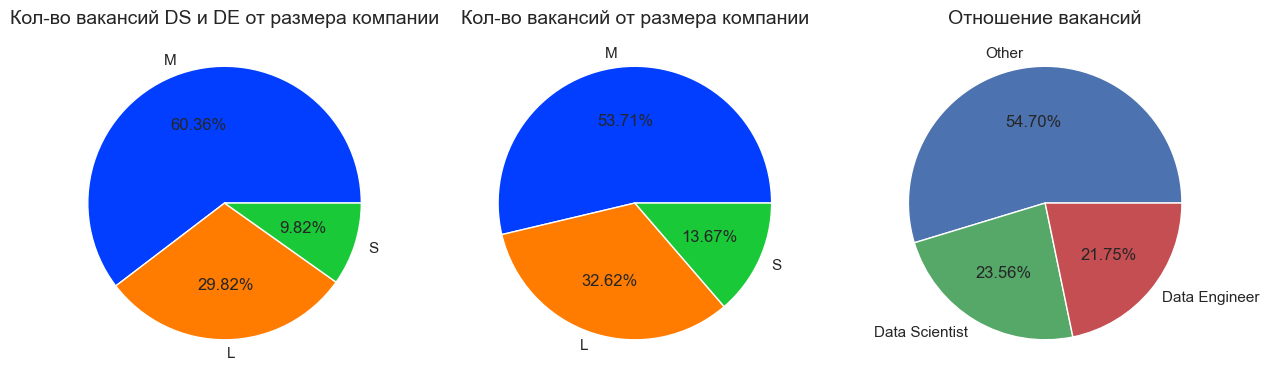

In [123]:
#Маска только с дата-инженерами и дата-саентистами
mask = salaries_data[(salaries_data['job_title'] == 'Data Engineer') | 
                       (salaries_data['job_title'] == 'Data Scientist')]

ax = sns.countplot(data=mask, x=mask['company_size'], hue='job_title')
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение дата-саентистов и дата-инженеров к размеру компании')
plt.show()

company_size_mask = mask['company_size'].value_counts()
company_size_mask_all = salaries_data['company_size'].value_counts()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
axes[0].pie(
    company_size_mask,
    labels=company_size_mask.index,
    colors=sns.color_palette('bright')[0:3],
    autopct='%.2f%%'
)

axes[1].pie(
    company_size_mask_all,
    labels=company_size_mask_all.index,
    colors=sns.color_palette('bright')[0:3],
    autopct='%.2f%%'
)

axes[2].pie(
    job_mask,
    labels=job_mask.index,
    colors=sns.color_palette('deep6')[0:3],
    autopct='%.2f%%'
)

axes[0].set_title('Кол-во вакансий DS и DE от размера компании', fontsize=14)
axes[1].set_title('Кол-во вакансий от размера компании', fontsize=14)
axes[2].set_title('Отношение вакансий', fontsize=14)

Судя по графикам, можно сделать вывод, что компании средних размеров чаще ищут себе дата-саентиста или дата-инженера, нежели компании других размеров, в размере рынка вакансий (53.71% вакансий от средних компаний всего, но при поиске именно специалиста DS или DE уже 60.36%).

Примечательно для меня, что большие компании не так сильно интересуются DS и DE. В случае же с малыми это объясняется их соответствующими бюджетами.

Мельком глянем на зависимость зарплаты от типа/графика работы.

In [124]:
grouped_data = salaries_data.groupby(
    by=['employment_type', 'job_title'],
    as_index=False)['salary_in_usd'].median()

fig7 = px.bar(
    data_frame=grouped_data,
    y='job_title',
    x='salary_in_usd',
    color='employment_type',
    barmode='group',
    labels={'salary_in_usd':'Заработная плата в USD',
            'job_title':'Должность',
            'employment_type':'Тип трудоустройства'
            },
    title='Зависимость заработной платы от типа/графика работы'
)

fig7.show()

C:\Users\telis\AppData\Local\Temp\ipykernel_47716\2183088492.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Как мы видим, среди дата-саентистов и дата-инженеров не распространён контрактный тип трудоустройства. Также видим огромный отрыв последних от всего рынка при трудоустройстве на неполный рабочий день, хоть он и всё равно не дотягивает до традиционного полного рабочего дня, тут всё стандартно. Также как видно из графика, имеются довольно профитные места, подразумевающие фриланс, у дата-саентистов.

## Статистический анализ данных

In [125]:
# функция для принятия решения о нормальности:
# принимает p-value, сравнивает с alpha и 
# возвращает о нормальности
def decision_normality(p):
    print(f'p-value = {p}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Распределение отлично от нормального')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha}. Распределение является нормальным')


# функция для принятия решения об отклонении нулевой гипотезы
# принимает p-value, сравнивает с alpha и 
# возвращает о нулевой гипотезе
def decision_hypothesis(p):
    print(f'p-value = {p}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha}. У нас нет оснований отвергнуть нулевую гипотезу.')
      

### <center> Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Напомню, до этого на основе визуального и описательного анализов был сделан вывод, что да, заработная плата увеличивалась.

**Сформулируем нулевую и альтернативную гипотезы:**
*Нулевая гипотеза ($H_0$)*: Ежегодный рост заработных плат отсутствует.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): Ежегодный рост заработных плат присутствует (Заработная плата растёт с каждым годом).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [126]:
data_science_2020 = data_scientist_mask.loc[data_scientist_mask['work_year']==2020, 'salary_in_usd']
data_science_2021 = data_scientist_mask.loc[data_scientist_mask['work_year']==2021, 'salary_in_usd']
data_science_2022 = data_scientist_mask.loc[data_scientist_mask['work_year']==2022, 'salary_in_usd']

print('2020 год:')
result = stats.shapiro(data_science_2020)
decision_normality(result[1])
print('-'*100)

print('2021 год:')
result = stats.shapiro(data_science_2021)
decision_normality(result[1])
print('-'*100)

print('2022 год:')
result = stats.shapiro(data_science_2022)
decision_normality(result[1])
print('-'*100)

2020 год:
p-value = 1.7172916383340651e-06
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
----------------------------------------------------------------------------------------------------
2021 год:
p-value = 0.12458308130600299
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
----------------------------------------------------------------------------------------------------
2022 год:
p-value = 0.32689495414273684
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
----------------------------------------------------------------------------------------------------


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в долларах»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет, так как доподлинно неизвестно, одни и те же ли вакансии у нас предствалены в выборке. А опираясь на предыдущие исследования, утверждать мы это не можем.
* Признак распределён по нормальному закону? — Частично да. Но так как нужно нормальное распределение во всех группах данных, считаем, что нет.

Для проверки нашей гипотезы можно использовать критерий Краскела-Уоллиса.

**Проведём тест**

In [127]:
# Тест Краскела-Уоллиса
_, p = stats.kruskal(data_science_2020, data_science_2021, data_science_2022)

decision_hypothesis(p)

p-value = 8.183831649960718e-10
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Как и было сказано ранее, разница в зарплатах есть, и она росла из года в год. Это видно по медианным значениям, и подтверждается тестом блоком выше.

### <center> Как соотносятся заработные платы Data Scientist и Data Engineer в 2022 году?

*Нулевая гипотеза* ($H_0$): размер заработных плат в Data Science ($μ_1$) статистически равен размеру заработных плат Data Engineer ($μ_2$) в 2022 году.

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработных плат в Data Science ($μ_1$) статистически отличается от заработных плат Data Engineer ($μ_2$) в 2022 году.
$$ H_1 : μ_1 \neq μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [128]:
# Маска для дата-инженеров. Для дата-саентистов
# используем маску, сформированную для предыдущего 
# теста
data_engineer_2022 = data_engineer_mask.loc[data_engineer_mask['work_year']==2022, 'salary_in_usd']

print('Data Science:')
result = stats.shapiro(data_science_2022)
decision_normality(result[1])
print('-'*100)

print('Data Engineer:')
result = stats.shapiro(data_engineer_2022)
decision_normality(result[1])

Data Science:
p-value = 0.32689495414273684
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
----------------------------------------------------------------------------------------------------
Data Engineer:
p-value = 0.009988683777503548
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в долларах»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признаки распределены по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [129]:
# проводим тест
_, p = stats.mannwhitneyu(data_science_2022, data_engineer_2022)
decision_hypothesis(p)

p-value = 0.1546491781563232
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Не достаточно оснований предполагать, что зарплаты сильно отличаются.

В принципе, это логично и прослеживается на графиках: медианная заработная плата дата-саентистов и третий квартиль больше, но первый квартиль и максимальная зафиксированная заработная плата больше именно у дата-инженеров. Следовательно, безоговорочного вывода сделать нельзя.

### <center> Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

*Нулевая гипотеза* ($H_0$): размер заработных плат в Data Scientist не зависит от размера компании (равен во всех случаях).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер заработных плат в Data Science разнится в зависимости от размера компании.
$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [130]:
# Создадим маски
data_science_small = data_scientist_mask.loc[data_scientist_mask['company_size']=='S', 'salary_in_usd']
data_science_med = data_scientist_mask.loc[data_scientist_mask['company_size']=='M', 'salary_in_usd']
data_science_large = data_scientist_mask.loc[data_scientist_mask['company_size']=='L', 'salary_in_usd']

print('Малые компании:')
result = stats.shapiro(data_science_small)
decision_normality(result[1])
print('-'*100)

print('Средние компании:')
result = stats.shapiro(data_science_med)
decision_normality(result[1])
print('-'*100)

print('Большие компании:')
result = stats.shapiro(data_science_large)
decision_normality(result[1])
print('-'*100)

Малые компании:
p-value = 0.18902802506301086
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
----------------------------------------------------------------------------------------------------
Средние компании:
p-value = 0.6389458463669577
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
----------------------------------------------------------------------------------------------------
Большие компании:
p-value = 3.353207973288722e-05
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
----------------------------------------------------------------------------------------------------
